### Title: 
# XGBOOST

### Description:
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.

The algorithm differentiates itself in the following ways:

- A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.

- Portability: Runs smoothly on Windows, Linux, and OS X.

- Languages: Supports all major programming languages including C++, Python, R, Java, Scala, and Julia.

- Cloud Integration: Supports AWS, Azure, and Yarn clusters and works well with Flink, Spark, and other ecosystems.

In this notebook, we will perform the XGBoost algorithm from the xgboost package, plot the confussion matrix and the ROC-AUC curve

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
04/12/2020

### Version:
1.0

***

### Libraries

In [1]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

    # Impot XGBoost
import xgboost as xgb

    # Import Sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import itertools

    #Import pickle
import pickle

## Functions

In [2]:
'''
This function prints and plots the confusion matrix:

cm = confussion_matrix using the prediction values
classes = name of the labels
cmap & tittle color map and tittle of the plot
'''
def plot_confusion_matrix(model_predictions, model_name,normalize = False): 
    cm = confusion_matrix(y_val, model_predictions, labels = [0, 1])
    classes=['Fully Pay', 'Non-payment']
    cmap = plt.cm.Reds
    title = f'{model_name} Confusion Matrix'
    fontsize = 12
    fontsize_lab = 15
    fontsize_tit = 20
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals = 3)
        
        # Plot params
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = fontsize_tit)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontsize = fontsize)
    plt.yticks(tick_marks, classes, fontsize = fontsize)
    
        # Itercool params
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label', fontsize = fontsize_lab)
    plt.xlabel('Predicted label', fontsize = fontsize_lab)

### Load data

In [3]:
# To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'X_train'

X_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'Y_train'

y_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'X_val'

X_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'Y_val'

y_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

In [4]:
    # Transform to 1d array
y_train = np.ravel(y_train)

## XGBoost Prediction

In [5]:
    # Train
xgboostreg = xgb.XGBClassifier(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    eta=0.1,
    max_depth=6,
    random_state = 1322,
    objective = 'binary:logistic')

xgboostreg.fit(X_train, y_train)

    # Predict with the test and calculate tha accuracy
y_pred = xgboostreg.predict(X_val)

print('Accuracy of XGBoost classifier on test set: {:.5f}'.format(xgboostreg.score(X_val, y_val)))

Accuracy of XGBoost classifier on test set: 0.80227


### Confussion Matrix

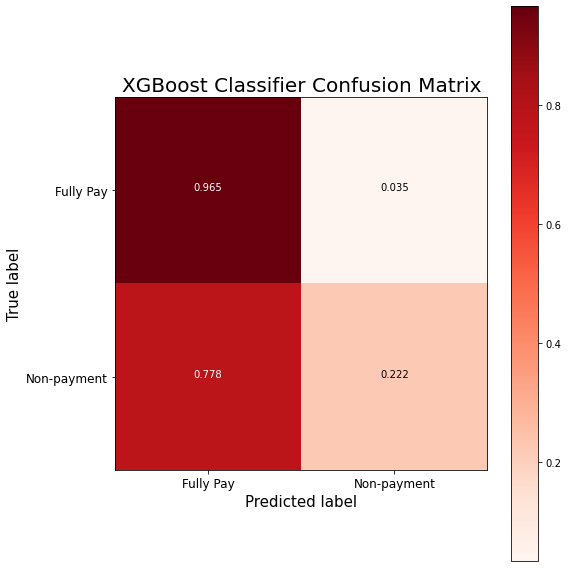

In [9]:
    # Set the size
plt.figure(figsize = (8, 8))

    # Use the function defined above
plot_confusion_matrix(y_pred, 'XGBoost Classifier', normalize = True)
plt.show()

Here we can see that our XGBoost is quite good predicting Fully Pay members as the other models, because we have more than a 96.5% of *True Positives*, but is not quite good predicting Non-payment clients, this is due from the total customers that non-pay we are predicting well more than 22%.

### Classsification Report

In [7]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.88     47720
           1       0.64      0.22      0.33     13378

    accuracy                           0.80     61098
   macro avg       0.73      0.59      0.61     61098
weighted avg       0.78      0.80      0.76     61098



We can see at the `classification_report` that our model predict very well Fully Pay customers, because we have a high precision (remember *Precision = TP/(TP + FP)*) and therefore our recall (*Recall = TP/(TP+FN)*) is almost 100% this makes that the f1-score (*F1 Score = 2(Recall · Precision) / (Recall + Precision)*) is 88%.

On the other hand, as we said above the XGBoost model is very poor predicting Non-payment clientes but better than the other models. The main issue is that the recall is very low, that means we can not detect all the Non-payment, in other words, we have a bigger amount of False Positives.

## ROC Curve

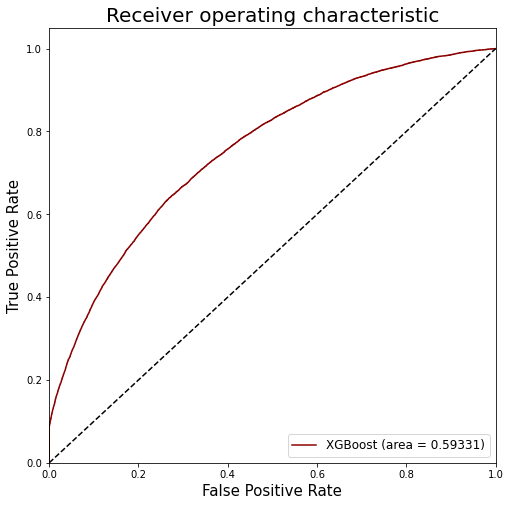

In [10]:
    # Create the roc score
xgb_roc_auc = roc_auc_score(y_val, xgboostreg.predict(X_val))

    # Create the curve
fpr, tpr, thresholds = roc_curve(y_val, xgboostreg.predict_proba(X_val)[:,1])

    # Set the figure size
plt.figure(figsize = (8, 8))

    # Params for the plot
plt.plot(fpr, tpr, '#8B0000', label = 'XGBoost (area = %0.5f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

    # Labels params
fontsize = 12
fontsize_lab = 15
fontsize_tit = 20

    # Labels, title and legend modifications
plt.xlabel('False Positive Rate', fontsize = fontsize_lab)
plt.ylabel('True Positive Rate', fontsize = fontsize_lab)
plt.title('Receiver operating characteristic', fontsize = fontsize_tit)
plt.legend(loc="lower right", fontsize = fontsize)

    # Save the figure for the final reprt
plt.savefig('XGBoost_ROC')

    # Show the plot
plt.show()

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

In this case we have an AUC = 0.59331 this is not very high, but is the best model we have.

In [11]:
#save the model to disk
model = xgboostreg
filename = "xgboost.sav"
pickle.dump(model, open(filename, 'wb'))